# Bayesian approach for sampling new seqs:
	1. Generate N seqs using transformer
	2. Generate average embeddings for each of the N seqs
	3. Tesselate the latent space using GMM with a number of clusters tuned to get good coverage (validated with tsne/umap)
	4. From each cluster ranomly sample desired_num_seqs * (N_cluster / N) sequences using a beta distributin to optionally bias the intra-cluster sampling to sequences with a given scalar property.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from biosynseq import visualize

In [2]:
# Steps 1, 2: Sequence generation and embedding average -- precomputed

path = Path("/homes/mzvyagin/mdh_gpt2/likely-wood-857/")

train_embed_path = path /"likely-wood-857-train_fasta_embeddings_mean.npy"
train_fasta_path = Path("/homes/mzvyagin/mdh_gpt2/train_folder_concatenated.fasta")

gen_embed_path = path / "likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy"
gen_fasta_path = path / "likely-wood-857_1024concat_seqs.fasta"

train_embed_avg = np.load(train_embed_path)
gen_embed_avg = np.load(gen_embed_path)

train_df = visualize.get_paint_df(train_fasta_path, train_embed_path)
gen_df = visualize.get_paint_df(gen_fasta_path, gen_embed_path)

/lambda_stor/homes/abrace/src/mdlearn/conda-env/lib/python3.7/site-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


<AxesSubplot:>

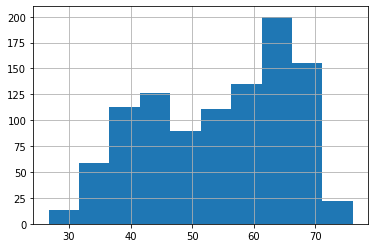

In [40]:
gen_df["GC"].hist()

In [3]:
all_data = np.concatenate([train_embed_avg, gen_embed_avg])

In [5]:
tsne_proj = visualize.run_tsne(all_data)
umap_proj = visualize.run_umap(all_data)

[W] [13:25:17.145008] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [9]:
# Step 3: Tessalation

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=40,
    covariance_type="diag",
    init_params="kmeans",
    random_state=42,
    verbose=True
)

gmm.fit(all_data)
bic = gmm.bic(all_data)
labels = gmm.predict(all_data)

print("BIC:", bic)

Initialization 0
  Iteration 10
Initialization converged: True
BIC: -252684141.96544465


In [38]:
# Visualize
def plot_overlay(
    proj: np.ndarray,
    paint: np.ndarray,
    paint_name: str,
    train_len: int,
    legend_label: str = "Generated",
) -> None:
    df = pd.DataFrame({
            "z0": proj[:train_len, 0],
            "z1": proj[:train_len, 1],
            paint_name: paint[:train_len],
    })
    ax = plt.scatter(x=df.z0, y=df.z1, c=df[paint_name], cmap="plasma", alpha=0.4)
    cbar = plt.colorbar(ax)
    cbar.set_label(paint_name)
    # Generated
    df = pd.DataFrame({
            "z0": proj[train_len:, 0],
            "z1": proj[train_len:, 1],
            paint_name: paint[train_len:],
    })
    plt.scatter(x=df.z0, y=df.z1, c="k", alpha=0.2, label=legend_label)
    plt.legend(loc="upper left")
    plt.show()

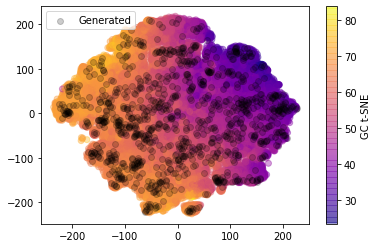

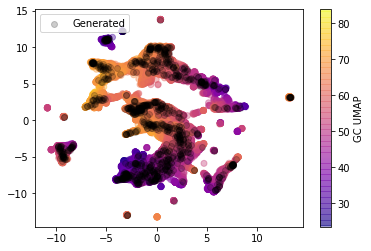

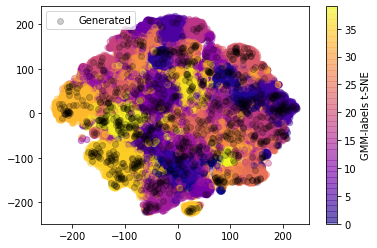

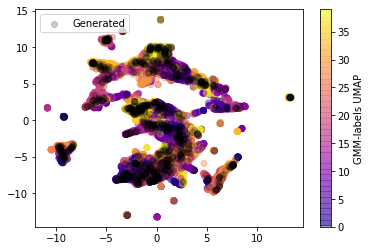

In [58]:
# Sequence metrics
paint_name = "GC"
paint = np.concatenate((train_df[paint_name].values, gen_df[paint_name].values))
plot_overlay(tsne_proj, paint, f"{paint_name} t-SNE", len(train_embed_avg))
plot_overlay(umap_proj, paint, f"{paint_name} UMAP", len(train_embed_avg))

# GMM Clusters
plot_overlay(tsne_proj, labels, "GMM-labels t-SNE", len(train_embed_avg))
plot_overlay(umap_proj, labels, "GMM-labels UMAP", len(train_embed_avg))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

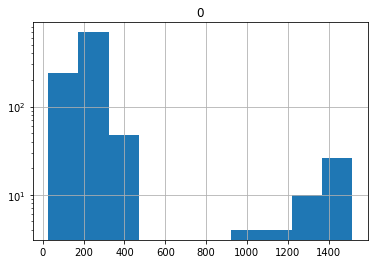

In [14]:
# Step 4: Compute sequence similarity -- precomputed
import json
from biosynseq.metrics import get_seqs_from_fasta

def load_needle_similarity(gen_fasta_path: Path):

    with open("likely-wood-287-seqs_needle_scores_against_2pwz.json") as f:
        data = json.load(f)
        
    # Need to sort these according to the order of the input fasta file
    similarity_map = {tup[1]: tup[2] for tup in data} # Map: sequence str -> similarity
    seqs = [str(record.seq) for record in get_seqs_from_fasta(gen_fasta_path)]
    sorted_similarity = [similarity_map[seq] for seq in seqs]
    return sorted_similarity    
    

needle_similarity = load_needle_similarity(gen_fasta_path) 
    
pd.DataFrame(needle_similarity).hist(log=True)

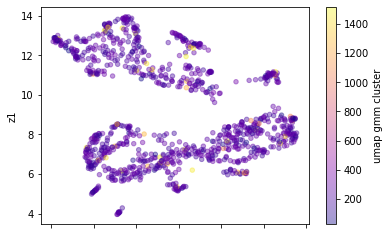

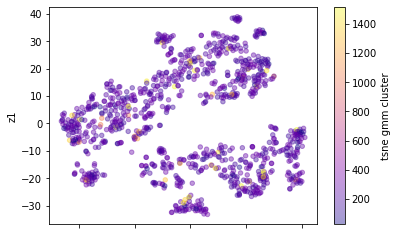

In [60]:
# Visualize
_ = visualize.plot_cluster(umap_output, needle_similarity, "umap gmm cluster")
_ = visualize.plot_cluster(tsne_output, needle_similarity, "tsne gmm cluster")

label: 0, count:  20
label: 1, count:  46
label: 2, count:  18
label: 3, count:  21
label: 4, count:  73
label: 5, count:  6
label: 6, count:  36
label: 7, count:  24
label: 8, count:  3
label: 9, count:  2
label: 10, count:  37
label: 11, count:  10
label: 12, count:  6
label: 13, count:  33
label: 14, count:  39
label: 15, count:  25
label: 16, count:  17
label: 17, count:  6
label: 18, count:  49
label: 19, count:  11
label: 20, count:  12
label: 21, count:  21
label: 22, count:  40
label: 23, count:  30
label: 24, count:  11
label: 25, count:  21
label: 26, count:  9
label: 27, count:  14
label: 28, count:  36
label: 29, count:  6
label: 30, count:  35
label: 31, count:  2
label: 32, count:  27
label: 33, count:  45
label: 34, count:  11
label: 35, count:  108
label: 36, count:  4
label: 37, count:  18
label: 38, count:  80
label: 39, count:  12


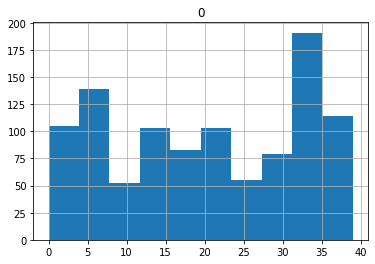

In [15]:
# Step 5: Sample desired_num_seqs * (N_cluster / N) sequences
gen_labels = labels[len(train_embed_avg):]
pd.DataFrame(gen_labels).hist()
for label in np.unique(gen_labels):
    print(f"label: {label}, count: ", len(gen_labels[gen_labels == label]))

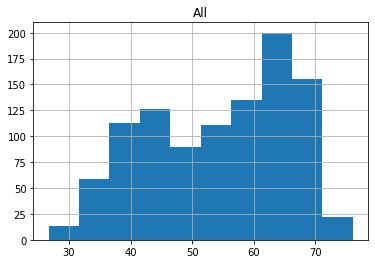

                 0
count  1024.000000
mean     54.458195
std      11.455122
min      26.688103
25%      44.478217
50%      56.363542
75%      64.693666
max      76.095238


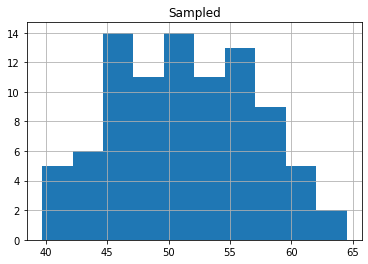

               0
count  90.000000
mean   51.213425
std     5.745090
min    39.697950
25%    46.453449
50%    51.164018
75%    55.693223
max    64.485981


In [90]:
def beta_sampling(
    metric: np.ndarray,
    labels: np.ndarray,
    num_to_sample: int,
    alpha: int = 1,
    beta: int = 15,
    seed: int = 0,
):
    """To maximize over the metric, choose alpha=20, beta=1.
    To minimize, choose alpha=1, beta=20. To uniformly sample,
    choose alpha=1, beta=1. To sample around the mean, choose
    alpha=beta=const (if you increase const, the samples will
    be very close to the mean. Decreasing const towards 1 will be more
    uniformly distributed. const < 1 will sample both tails.)
    """
    np.random.seed(seed)
    n_examples = len(metric)
    assert n_examples == len(labels)
    assert num_to_sample <= n_examples
    
    clusters = np.unique(labels)
    n_clusters = len(clusters)
    original_inds = np.arange(n_examples)
    
    sampled_inds = {}
    
    for label in clusters:
        # Consider a given cluster
        mask = labels == label
        # Within the cluster, sort the indices by the metric (low to high)
        cluster_inds = np.argsort(metric[mask])
        # Compute the size of the given cluster
        n_cluster = len(cluster_inds)
        # Sample n_cluster / n_seqs samples from the 
        # given cluster in proportion to the metric
        sample_inds = (np.random.beta(a=alpha, b=beta, size=(1000,)) * n_cluster).astype(int)
        # Get unique inds while preserving order
        unique, inds = np.unique(sample_inds, return_index=True)
        unique_inds = unique[np.argsort(inds)]
        unique_inds = cluster_inds[unique_inds]
        # Keep num_to_sample * (n_cluster / n_examples) samples per cluster
        num_to_sample_in_cluster = round(num_to_sample * n_cluster / n_examples)
        assert len(unique_inds) > num_to_sample_in_cluster, "Not enough unique points sampled, run again"
        # Only keep up to num_to_sample_in_cluster per cluster
        unique_inds = unique_inds[:num_to_sample_in_cluster]
        # Get the original indices of the full dataset
        real_inds = original_inds[mask][unique_inds]
        sampled_inds[label] = real_inds
  
    return sampled_inds
    
    
# As an example, minimize sequence length in each cluster
metric = gen_df["GC"].values.copy()
sampled_inds = beta_sampling(metric, gen_labels, num_to_sample=90, alpha=10, beta=16, seed=50)
inds = np.concatenate(list(sampled_inds.values()))

df = pd.DataFrame(metric)
df.hist()
plt.title("All")
plt.show()
print(df.describe())
df = pd.DataFrame(metric[inds])
df.hist()
plt.title("Sampled")
plt.show()
print(df.describe())

# Run with num_to_sample=100, alpha=1, beta=1, seed=40
# To get uniform sample: GMM-uniform-sample-filtered.fasta

- 1/3 random beta=alpha=1
- We could try sampling for higher chemguass
- Choosing closness to a set of sequences pwz

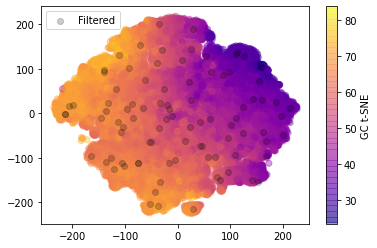

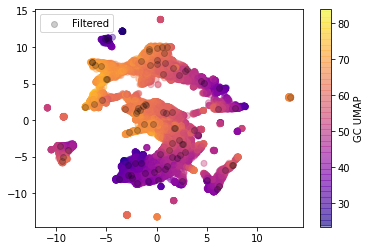

In [94]:
# Visualize sampled subset against training data
paint_name = "GC"
train_len = len(train_embed_avg)
paint = np.concatenate((train_df[paint_name].values, gen_df[paint_name].values[inds]))
tsne_subsample_proj = np.concatenate((tsne_proj[:train_len], tsne_proj[train_len:][inds]))
umap_subsample_proj = np.concatenate((umap_proj[:train_len], umap_proj[train_len:][inds]))
plot_overlay(tsne_subsample_proj, paint, f"{paint_name} t-SNE", train_len, "Filtered")
plot_overlay(umap_subsample_proj, paint, f"{paint_name} UMAP", train_len, "Filtered")

# Note: We are not actually sampling high GC-content sequences, rather
#       we are sampling lower GC (>65%) sequences from regions in the
#       latent space where higher GC-content sequences are clustered.

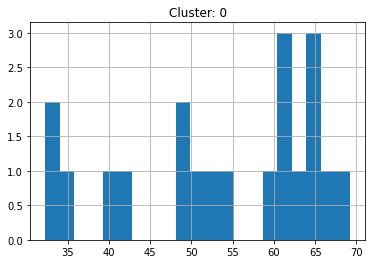

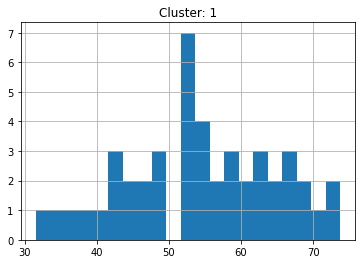

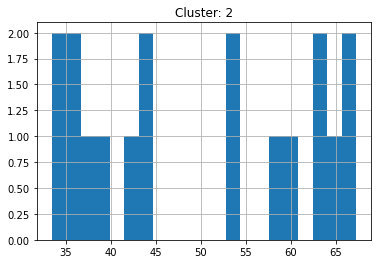

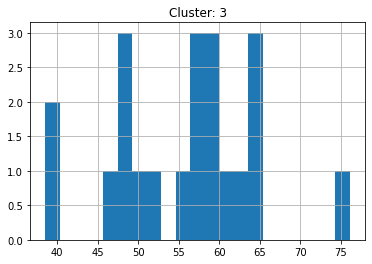

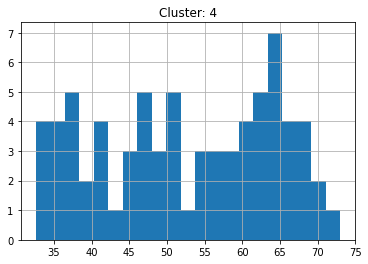

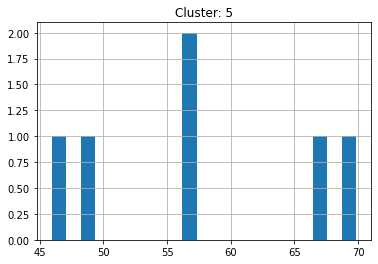

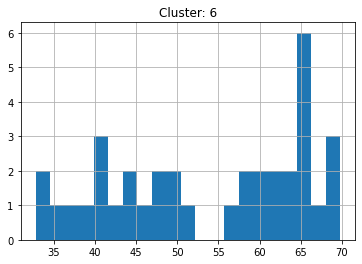

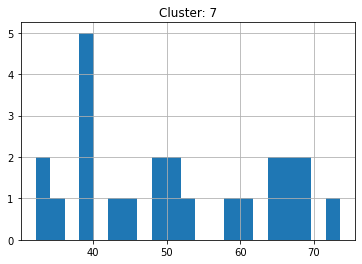

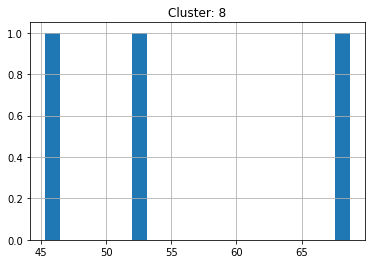

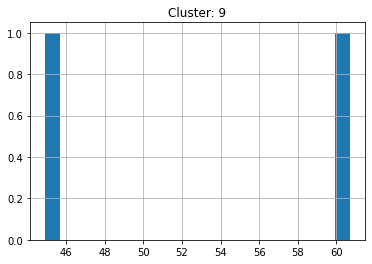

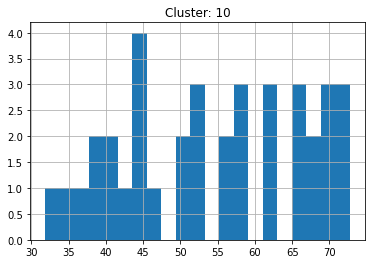

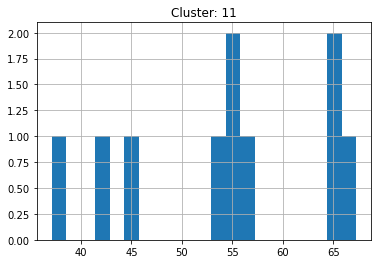

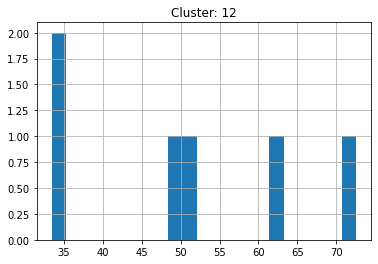

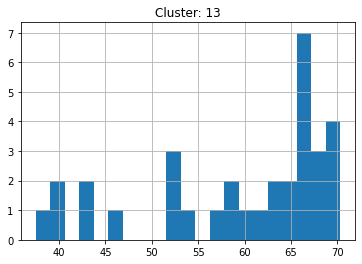

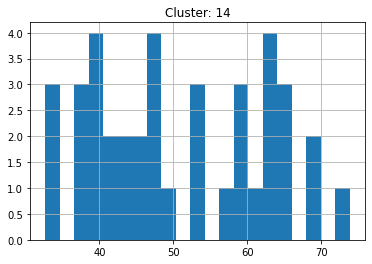

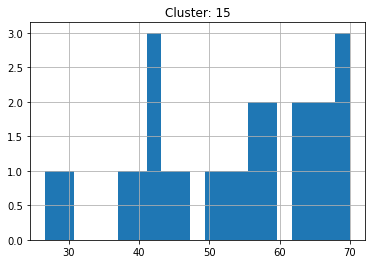

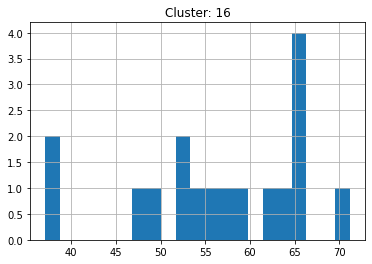

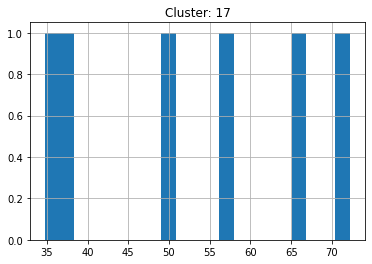

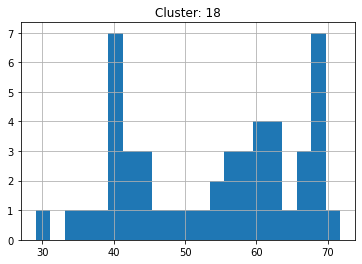

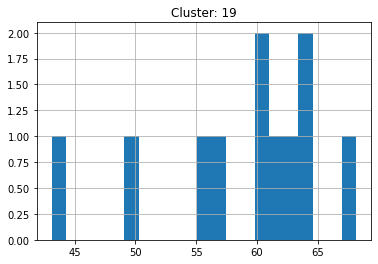

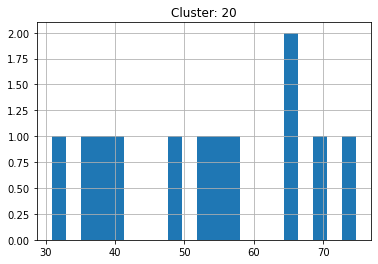

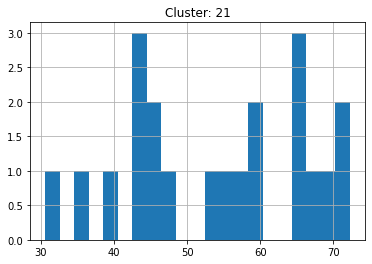

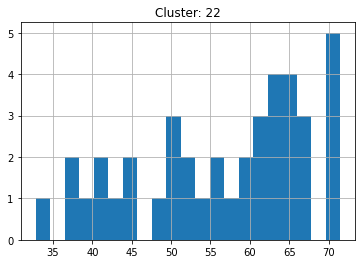

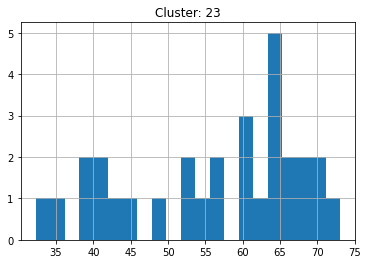

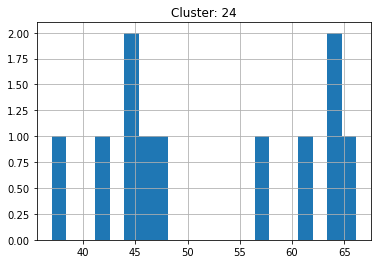

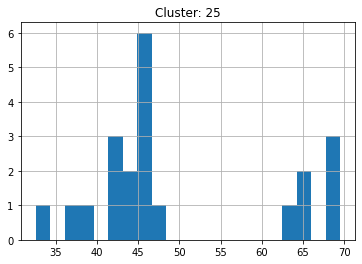

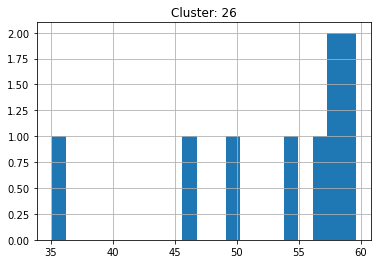

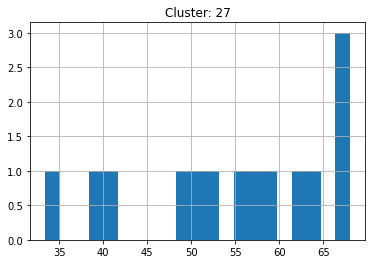

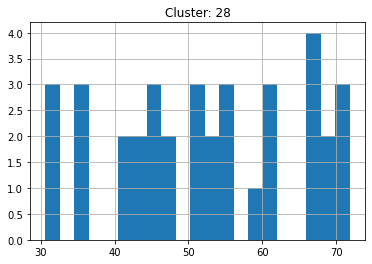

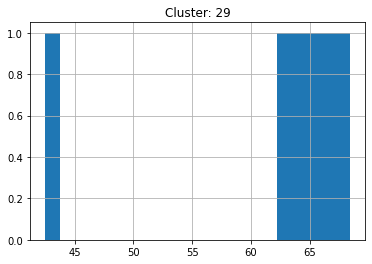

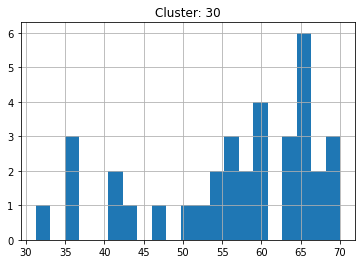

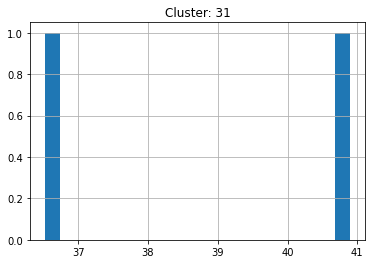

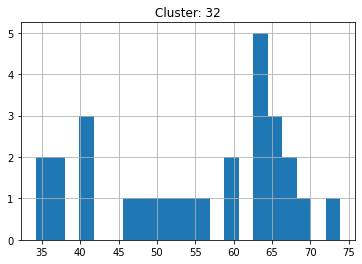

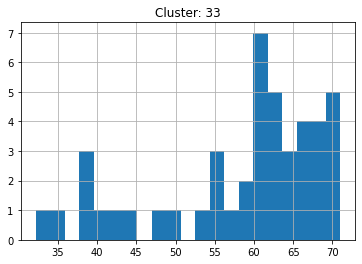

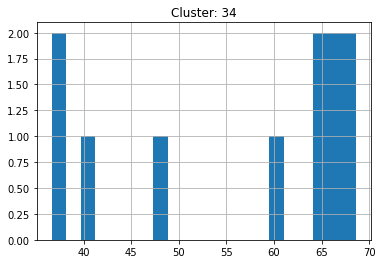

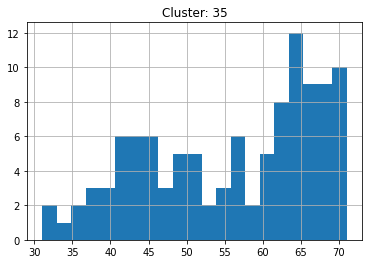

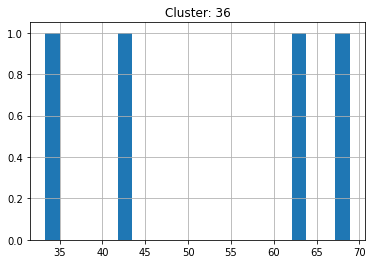

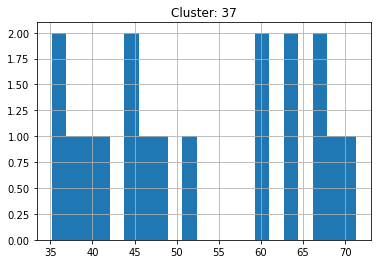

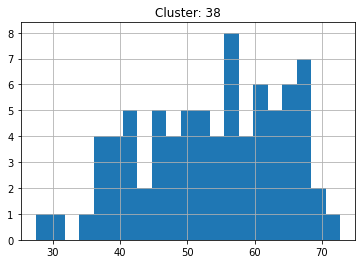

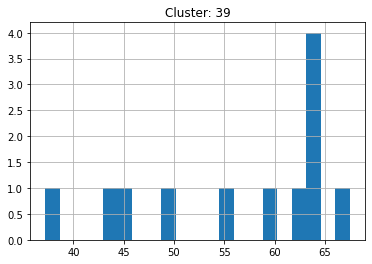

In [92]:
import matplotlib.pyplot as plt

clusters = np.unique(labels)

for label in clusters:
    # Consider a given cluster
    mask = gen_labels == label
    pd.DataFrame(metric[mask]).hist(bins=21)
    plt.title(f"Cluster: {label}")
    plt.show()

In [93]:
# The final output sequences
from Bio import SeqIO
from biosynseq.metrics import get_seqs_from_fasta

gen_seqs = get_seqs_from_fasta(gen_fasta_path)
assert len(gen_seqs) == len(gen_df)

filtered_seqs = [gen_seqs[i] for i in inds]

print("Number of filtered sequences:", len(filtered_seqs))

# Make names shorter
name = "LikelyWood857"
for i, seq in zip(inds, filtered_seqs):
    seq.id = f"{name}-{i}"
    seq.description = ""

# Writing output sequences
SeqIO.write(filtered_seqs, "GMM-alpha-10-beta-16-seed-50-filtered.fasta", "fasta")

Number of filtered sequences: 90


90

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

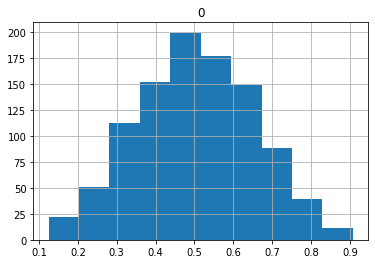

In [40]:
# Beta plotter: Adjust a, b to see the sampling behavior
samples = np.random.beta(a=5, b=5, size=(1000,))
pd.DataFrame(samples).hist()

# Phylogeny

In [ ]:
# TODO: Could try frobenius norm of the entire (Seqlength, D) tensors.

In [32]:
import itertools
import numpy as np
from tqdm import tqdm
from typing import List
from Bio.SeqRecord import SeqRecord
from scipy.spatial import distance_matrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix

def get_distance(embed: np.ndarray, seqs: List[SeqRecord]):
    """Return a DistanceMatrix for transformer embeddings.
    
    Parameters
    ----------
    embed : np.ndarray
        The (N, D) embedding tensor when N is the number of examples
        and D is the hidden dimension.
        
    seqs : List[Bio.SeqRecord]
        List of seqs such that seqs[i] corresponds to embed[i].
            
    """
    pairwise_dists = distance_matrix(embed, embed)
    #names = [s.id for s in seqs]
    names = list(str(i) for i in range(len(seqs)))
    dm = DistanceMatrix(names)
    for seq1_id, seq2_id in tqdm(itertools.combinations(names, 2)):
        dm[seq1_id, seq2_id] = pairwise_dists[int(seq1_id), int(seq2_id)]
    return dm

In [27]:
from pathlib import Path
from biosynseq.metrics import get_seqs_from_fasta

path = Path("/homes/mzvyagin/mdh_gpt2/likely-wood-857")
gen_embed_path = path / "likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy"
gen_fasta_path = path / "likely-wood-857_1024concat_seqs.fasta"

gen_embed_avg = np.load(gen_embed_path)
gen_seqs = get_seqs_from_fasta(gen_fasta_path)

In [33]:
# https://github.com/biopython/biopython/blob/master/Bio/Phylo/TreeConstruction.py#L546
constructor = DistanceTreeConstructor()

In [34]:
dm = get_distance(gen_embed_avg, gen_seqs)

523776it [01:55, 4546.07it/s]


In [35]:
tree = constructor.nj(dm)

In [37]:
import Bio.Phylo as Phylo
Phylo.write(tree, "mdh-tree-generated-embed.xml", "phyloxml")
Phylo.write(tree, "mdh-tree-generated-embed.tree", "newick")

1

# Constructing an MSA

```
conda install -c bioconda clustalo
nohup clustalo --in=val.fasta --out=output.aln --force --outfmt=clustal --wrap=80 --threads=40 -v &> mdh_val_msa.out &
```